In [1]:
import json
import abc
import matplotlib.pyplot as plt
import numpy as np
import requests
from datetime import datetime, timedelta
from pytz import UTC
import pickle

In [2]:
apikeys = {'metObs': ""}

In [3]:
class weather_int(abc.ABC):
    @abc.abstractmethod
    def __init__(self, starttime: datetime, endtime: datetime) -> None:
        self._starttime = starttime
        self._endtime = endtime

    @property
    def endtime(self):
        return self._endtime.astimezone(UTC)
    
    @endtime.setter
    def endtime(self, date: datetime):
        self._endtime = date

    @property
    def starttime(self):
        return self._starttime.astimezone(UTC)
    
    @starttime.setter
    def starttime(self, date: datetime):
        self._starttime = date

    @abc.abstractmethod
    def output_csv(self, data, print_header = True, filename = "./weather.csv" ):
        pass

    @abc.abstractmethod
    def extract_weather(self):
        pass




class metObs(weather_int):
    _apikey = "api-key=" + apikeys["metObs"]
    _baselink = "https://dmigw.govcloud.dk/v2/metObs/collections/observation/items/?"
    def __init__(self, starttime: datetime, endtime: datetime, station = 6030) -> None:
        super().__init__(starttime, endtime)
        self._station = station  # Default Aalborg
        # Set parameter config
        self._parameter_id = {
            "humidity":[True, 10, "%"],
            "precip_dur_past10min":[True, 10, "kg/m²"],
            "precip_past10min":[True, 10, "min"],
            "precip_past1min":[True, 10, "min"],
            "pressure":[True, 10, "hPa"],
            "pressure_at_sea":[False, 10, "hPa"],
            "temp_dew":[True, 10, "degC"],
            "temp_dry":[True, 10, "degC"],
            "temp_grass":[False, 10, "degC"],
            "visib_mean_last10min":[False, 10, "m"],
            "visibility":[False, 10, "m"],
            "weather":[False, 10, "Code"],
            "wind_dir":[False, 10, "degree"],
            "wind_max":[False, 10, "m/s"],
            "wind_min":[False, 10, "m/s"],
            "wind_speed":[False, 10, "m/s"],
            "precip_dur_past1h":[False, 60, "min"],
            "precip_past1h":[False, 60, "kg/m²"],
            "temp_max_past1h":[False, 60, "degC"],
            "temp_mean_past1h":[False,60, "degC"],
            "temp_min_past1h":[False, 60, "degC"],
            "humidity_past1h":[False, 60, "%"],
            "temp_grass_max_past1h":[False,60,"degC"],
            "temp_grass_mean_past1h":[False,60,"degC"],
            "temp_grass_min_past1h":[False,60,"degC"],
            "wind_dir_past1h":[False,60,"degree"],
            "wind_gust_always_past1h":[False,60,"m/s"],
            "wind_max_per10min_past1h":[False,60,"m/s"],
            "wind_min_past1h":[False,60,"m/s"],
            "wind_speed_past1h":[False,60,"m/s"],
            }

    # Dataclass for processed JSON Query.    
    class metObsSample:
        def __init__(self, sample) -> None:
            properties = sample["properties"]
            try:
                self.coord = sample["geometry"]["coordinates"]
            except:
                self.coord = None
            self.observedTime = datetime.strptime(properties["observed"], "%Y-%m-%dT%H:%M:%S%z")
            self.parameterId = properties["parameterId"]
            self.value = properties["value"]
            pass 
    
    @property
    def station(self):
        if self._station / 10000 < 1:
            return "0" + str(self._station)
        else:
            return str(self.station)
    
    @station.setter
    def station(self, val:int):
        self._station = val

    @property
    def query_date(self):
        format_string = "%Y-%m-%dT%H:%M:%SZ"
        starttime = datetime.strftime(self.starttime - timedelta(minutes=self.starttime.minute, seconds=self.starttime.second), format_string)
        endtime = datetime.strftime(self.endtime - timedelta(minutes=self.endtime.minute, seconds=self.endtime.second), format_string)
        return f"{starttime}/{endtime}"

    @property
    def parameters(self):
        keys = list(self._parameter_id.keys())
        params = list(key for key in keys if self._parameter_id[key][0] == True)
        return params
    @parameters.setter
    def parameters(self, parameter): 
        self._parameter_id[parameter][0] = not self._parameter_id[parameter][0] 
        return

    # Request a parameter from DMI API.
    def _extract_parameter(self, parameter: str):
        count = int((self.endtime - self.starttime).total_seconds() // (self._parameter_id[parameter][1]*60))
        query = self._baselink + self._apikey + f"&stationId={self.station}&parameterId={parameter}&datetime={self.query_date}&limit={str(count+500)}"
        r = requests.request("GET", query)
        x = [self.metObsSample(index) for index in json.loads(r.content)["features"]]
        return x
    
    #Extract All active paramters from DMI.
    def extract_weather(self, sorttime = False):
        output = {}
        for param in self.parameters:
            tmp = self._extract_parameter(param)
            if len(tmp) == 0:
                    self.parameters = param # Remove from parameter list
                    continue
            if sorttime:
                for data in tmp:
                    if data.observedTime not in output:
                        output[data.observedTime] = {param:data.value}
                    else:
                        output[data.observedTime][param] = data.value
            else:
                output[param] = tmp
        if sorttime: output =  {date:output[date] for date in sorted(output)}
        return output
    
    # Format as CSV, and print to file 
    def output_csv(self, data, print_header=True, filename="./weather.csv"):
        def generate_line(line):
            output = line[0]
            for i in line[1:]:
                output = output + "," + str(i)
            return output
        format_str = "%Y-%m-%dT%H:%M:%SZ"
        params = self.parameters
        header1 = generate_line(["Time"] + params)
        header2 = generate_line(["UTC"] + list(self._parameter_id[x][2] for x in params))    
        with open(filename, 'w') as f:
            if print_header:
                f.write(header1 + "\n")
                f.write(header2 + "\n")
            for item in data:
                line = [datetime.strftime(item, format_str), *(0 for _ in range(len(params)))] 
                for i, param in enumerate(params):
                    if param in data[item]:
                        line[i+1] = data[item][param]
                    else:
                        line[i+1] = "NaN"
                f.write(generate_line(line) + "\n")
        return
    







In [4]:
years = [2014, 2016, 2018, 2020, 2022, 2024, 2025]

precip_1m_val = []
precip_1m_time = []
precip_10m_val = []
precip_10m_time = []
for i in range(1,len(years)):
    with open(f"dmi_{years[i-1]}_{years[i]}.bin", 'rb') as f:
        data = pickle.loads(f.read())
    f.close()
    precip_1m_tmp = data["precip_past1min"][:-1]
    precip_1m_val_tmp = np.flip(np.array([i.value for i in precip_1m_tmp]))
    precip_1m_time_tmp = np.flip(np.array([i.observedTime.timestamp() for i in precip_1m_tmp]))
    # precip_1m_time = precip_1m_time - precip_1m_time[0]
    precip_10m_tmp = data["precip_past10min"][:-1]
    precip_10m_val_tmp = np.flip(np.array([i.value for i in precip_10m_tmp]))
    precip_10m_time_tmp = np.flip(np.array([i.observedTime.timestamp() for i in precip_10m_tmp]))
    print(f"t: {precip_10m_tmp[0].observedTime}, {precip_10m_tmp[-1].observedTime}")
    print(f"10m: {precip_10m_time_tmp[0]}, {precip_10m_time_tmp[-1]}")
    print(f"1m: {precip_1m_time_tmp[0]}, {precip_1m_time_tmp[-1]}")
    precip_1m_time.extend(precip_1m_time_tmp)
    precip_1m_val.extend(precip_1m_val_tmp)
    precip_10m_time.extend(precip_10m_time_tmp)
    precip_10m_val.extend(precip_10m_val_tmp)


t: 2016-01-01 00:00:00+00:00, 2014-01-01 00:10:00+00:00
10m: 1388535000.0, 1451606400.0
1m: 1423023720.0, 1451571000.0
t: 2018-01-01 00:00:00+00:00, 2016-01-01 00:10:00+00:00
10m: 1451607000.0, 1514764800.0
1m: 1451641320.0, 1514733600.0
t: 2020-01-01 00:00:00+00:00, 2018-01-01 00:10:00+00:00
10m: 1514765400.0, 1577836800.0
1m: 1514780520.0, 1577727000.0
t: 2022-01-01 00:00:00+00:00, 2020-01-01 00:10:00+00:00
10m: 1577837400.0, 1640995200.0
1m: 1577867520.0, 1640946000.0
t: 2024-01-01 00:00:00+00:00, 2022-01-01 00:10:00+00:00
10m: 1640995800.0, 1704067200.0
1m: 1641045720.0, 1704066000.0
t: 2025-01-01 00:00:00+00:00, 2024-01-01 00:10:00+00:00
10m: 1704067800.0, 1735689600.0
1m: 1704067320.0, 1735682400.0


In [5]:
print(6*24*365.2425*11)
print(len(precip_10m_time))
print(6*24*365*2)
print(precip_10m_time[0])
print(precip_10m_time[-1])

578544.12
574147
105120
1388535000.0
1735689600.0


In [6]:

ran = np.arange(precip_10m_time[0], precip_10m_time[-1], 60)
val = []

idx = 0
for i, t in enumerate(ran):
    if idx < len(precip_1m_time) and (precip_1m_time[idx] == t):
        val.append(precip_1m_val[idx])
        idx += 1
    else:
        val.append(0.0)

val = np.array(val)

In [7]:
print(len(precip_10m_time), len(precip_1m_val), len(ran))
print(precip_10m_time[0], precip_10m_time[-1])
print(ran[0], ran[-1])
print(precip_1m_time[0], precip_1m_time[-1])

574147 299984 5785910
1388535000.0 1735689600.0
1388535000.0 1735689540.0
1423023720.0 1735682400.0


In [8]:

idxs = np.argwhere(np.array(precip_1m_val) > 2)
for idx in idxs:
    print(idx)
    ts = precip_1m_time[idx[0]]
    print(datetime.fromtimestamp(ts))
    print(precip_1m_val[idx[0]])

[34289]
2016-03-05 19:22:00
2.6
[102152]
2018-08-23 19:36:00
2.1
[204105]
2021-12-01 08:40:00
2.1


In [9]:
%matplotlib tk
#plt.plot(precip_1m_val)
plt.figure()
plt.scatter(precip_1m_time, precip_1m_val, color='tab:blue', label = 'precip 1m')
#plt.scatter(precip_10m_time, precip_10m_val, color="tab:orange", label = 'precip10m', alpha=0.5)
plt.scatter(ran, val, color='tab:green', label = 'recon', marker='x')
plt.legend()

In [10]:
from tqdm import tqdm
def get_state(state_values, curr_value):
    return np.where(np.isclose(state_values, curr_value))[0][0]

states_values = np.unique(val)
print(states_values)
s_range = np.arange(len(states_values))
print(s_range)

state_counter = np.zeros((len(states_values),len(states_values)),dtype=np.float32)

prev_state = get_state(states_values, val[0])
for i in tqdm(range(1, len(val))):
    gcs = get_state(states_values, val[i])
    state_counter[prev_state, gcs] += 1
    prev_state = gcs

P = state_counter



[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 2.1 2.6]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


100%|██████████| 5785909/5785909 [02:29<00:00, 38823.57it/s]


In [ ]:
P = state_counter
for i in range(len(states_values)):
    state_sum = np.sum(P[i,:])
    if state_sum > 0:
        P[i,:] = P[i,:] / state_sum
print(P)

[[9.91581857e-01 8.18171818e-03 1.89752391e-04 3.00528645e-05
  7.16376417e-06 3.66924519e-06 2.09671157e-06 1.22308177e-06
  3.49451909e-07 6.98903818e-07 0.00000000e+00 1.74725955e-07
  3.49451909e-07 1.74725955e-07 0.00000000e+00 0.00000000e+00
  1.74725955e-07 0.00000000e+00 1.74725955e-07 1.74725955e-07
  1.74725955e-07]
 [8.17837298e-01 1.55545890e-01 2.15751044e-02 3.49443662e-03
  7.64951343e-04 2.95549369e-04 2.60778848e-04 1.39082054e-04
  3.47705136e-05 3.47705136e-05 1.73852568e-05 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.88622767e-01 4.21556890e-01 1.89221561e-01 6.19760491e-02
  2.15568859e-02 9.58083849e-03 3.29341320e-03 1.79640716e-03
  2.99401203e-04 8.98203580e-04 2.99401203e-04 2.99401203e-04
  2.99401203e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.99401203e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.31729662e-01

/home/dyb/miniconda3/envs/godot/lib/python3.12/tkinter/__init__.py:862: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args)


In [12]:
# np.save('aau_model',P)
# np.save('aau_states',states_values)
P = np.load('aau_model.npy')
states_values = np.load('aau_states.npy')

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
sns.heatmap(state_counter, 
            annot=True, 
            fmt=".4f", 
            cmap="viridis", 
            xticklabels=states_values,
            yticklabels=states_values,)
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.title("Markov Transition Matrix Heatmap")
plt.tight_layout()
plt.show()


In [14]:
N = int(1e3)
states = np.zeros(N, dtype=np.int8)
fake_rain = np.zeros(N, dtype=np.float32)
for i in tqdm(range(1, N)):
    prev_state = states[i-1]
    curr_state = np.random.choice(s_range,1,True,P[prev_state,:])
    states[i] = curr_state
    fake_rain[i] = states_values[curr_state]

  0%|          | 0/999 [00:00<?, ?it/s]/tmp/ipykernel_853896/303941195.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  states[i] = curr_state
/tmp/ipykernel_853896/303941195.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fake_rain[i] = states_values[curr_state]
100%|██████████| 999/999 [00:00<00:00, 27478.83it/s]


In [15]:
%matplotlib tk
plt.plot(precip_1m_val)
plt.figure()
plt.hist(val[val > 0.1], color='tab:blue', label = 'real', alpha=0.5, bins=100)
plt.hist(fake_rain[fake_rain > 0.1], color='tab:orange', label = 'fake', alpha=0.5, bins=100)
plt.legend()

In [16]:
%matplotlib tk
plt.plot(precip_1m_val)
plt.figure()
plt.scatter(ran, val, color='tab:blue', label = 'Real data', marker='x')
plt.scatter(ran, fake_rain, color='tab:orange', label = 'markov data', marker='x')
plt.legend()

ValueError: x and y must be the same size

/home/dyb/miniconda3/envs/godot/lib/python3.12/tkinter/__init__.py:862: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args)


In [ ]:
pi = P[15,:]
for i in range(int(1e7)):
    pi = pi @ P
print(pi)


21
[9.8913497e-01 9.9410415e-03 5.7724403e-04 1.5087845e-04 6.0316816e-05
 3.7503578e-05 2.1949103e-05 1.3480551e-05 7.4315858e-06 5.8761375e-06
 3.9750344e-06 2.5924137e-06 3.1108966e-06 1.0369655e-06 5.1848269e-07
 6.9131033e-07 8.6413797e-07 3.4565514e-07 1.7282755e-07 3.4565511e-07
 1.7282755e-07]


[  0.   6.  12.  18.  24.  30.  36.  42.  48.  54.  60.  66.  72.  78.
  84.  90.  96. 102. 108. 126. 156.]


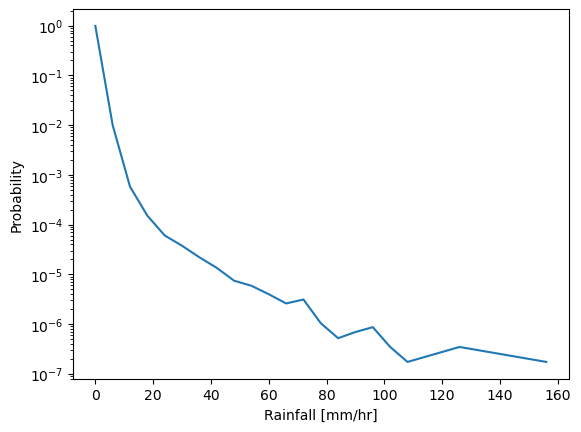

In [ ]:
print(states_values*60)
plt.figure()
plt.plot(states_values*60, pi)
plt.yscale('log')
plt.ylabel('Probability')
plt.xlabel('Rainfall [mm/hr]')
plt.show()